In [1]:
import math 
from sklearn.decomposition import FastICA
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tools21cm as t2c
from scipy import interpolate, stats
import matplotlib.colors as colors

base = '/home/ppxjf3/SKAO_DATA_CHALLENGE/bright_source_removal/'

In [2]:
import matplotlib.font_manager
import matplotlib as mpl

column_width=240# call "\the\columnwidth" in LaTeX to find
ppi=72#default ppi, can be left the same

scale=2
fig_width=column_width/ppi*scale#inches
fig_height=3*scale#inches

##SET FONT SIZES
font_small_size = 9
font_medium_size = 12
font_bigger_size =14

plt.rc('font', size=font_small_size) # controls default text sizes
plt.rc('axes', titlesize=font_small_size) # fontsize of the axes title
plt.rc('axes', labelsize=font_medium_size) # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_bigger_size) # fontsize of the tick labels
plt.rc('ytick', labelsize=font_bigger_size) # fontsize of the tick labels
plt.rc('legend', fontsize=font_small_size) # legend fontsize
plt.rc('figure', titlesize=font_bigger_size)


#correct font for MNRAS
#can be found at https://www.fontsquirrel.com/fonts/nimbus-roman-no9-l
#can be installed on Unix systems by putting unzipped folder in directory /home/{user}/.fonts
#run "fc-cache -v" in console to inform system of new font
#print(matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf'))
#plt.rc('font', family='Nimbus Roman')
# mpl.rcParams["font.family"] = "Nimbus Roman"
# mpl.rcParams['mathtext.fontset'] = 'custom'
# mpl.rcParams['mathtext.rm'] = 'Nimbus Roman'
# mpl.rcParams['mathtext.it'] = 'Nimbus Roman:italic'
# mpl.rcParams['mathtext.bf'] = 'Nimbus Roman:bold'
"""
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)
"""

#DPI of MNRAS is 300
mpl.rcParams['figure.dpi'] = 300/scale
# Set up a figure with four panels, with two rows and columns

In [3]:
ppi=72#default ppi, can be left the same
scale=2
column_width=240# call "\the\columnwidth" in LaTeX to find
fig_width=column_width/ppi*scale#inches
fig_height=3*scale#inches

##SET FONT SIZES
font_small_size = 9
font_medium_size = 12
font_bigger_size = 14

plt.rc('font', size=font_small_size) # controls default text sizes
plt.rc('axes', titlesize=font_small_size) # fontsize of the axes title
plt.rc('axes', labelsize=font_medium_size) # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_bigger_size) # fontsize of the tick labels
plt.rc('ytick', labelsize=font_bigger_size) # fontsize of the tick labels
plt.rc('legend', fontsize=font_small_size) # legend fontsize
plt.rc('figure', titlesize=font_bigger_size)
#DPI of MNRAS is 300
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300/scale

In [4]:
def pearson_correl(x,y):
 return (np.sum((x-np.mean(x))*(y-np.mean(y))))/(np.sqrt(np.sum((x-np.mean(x))**2)*np.sum((y-np.mean(y))**2)))

In [5]:
def do_fastica(data, comps, shape):
    f_ica = FastICA(n_components=comps)
    #generate the 4 componets
    S = f_ica.fit_transform(data.reshape((shape[0]*shape[1],shape[2])))
    
    #get mixing matrix
    A = f_ica.mixing_
    
    #make model
    model_fICA = (np.matmul(A,S.T).T).reshape((shape[0],shape[1],shape[2]))
    
    #get resids
    resids_fICA = data - model_fICA #residuals 
    
    return model_fICA, resids_fICA, S, A

In [6]:
def TFromJyBeam(jb, theta_max, theta_min, nu):
    """
    Convert from Jy/Beam to brightness temperature
    
    https://science.nrao.edu/facilities/vla/proposing/TBconv
    
    Units: theta_min, theta_max [deg]
           jb [Jy/beam]
           nu [MHz]
           tbright [K]
           
    (definitions use arcsec, mJy/beam and GHz, so convert those in code)
    """
    
    tbright = 1.222e3 * (jb * 1e3)
    tbright /= np.power(nu / 1.0e3, 2.0) * (theta_max * theta_min * 3600**2)
    
    return tbright


In [7]:
#cut so just primary beam
def primary_beam(data):
    idx0 = 2048//2 - 1024//2

    idx1 = 2048//2 + 1024//2
    pixel_size = idx1 -idx0


    return data[:,idx0:idx1, idx0:idx1] 

In [16]:
def get_plots_cc (reshape_sub_img, c, reshape_arr):
    model7, resids7, S_7, A = do_fastica(reshape_sub_img, c, reshape_sub_img.shape)
    
    arr_K = TFromJyBeam(resids7, theta_max = bmaj[0:75], theta_min = bmin[0:75], nu = np.arange(106,113.5,0.1)) 
    
    fig, ax = plt.subplots(figsize=(fig_width*2, fig_height),
                       nrows=2, ncols=2,)
    
    im1 = ax[0,0].imshow(truth[0,:,:])
    divider = make_axes_locatable(ax[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical', label='K')
    
    im2 = ax[0,1].imshow(resids7[:,:,0])
    divider = make_axes_locatable(ax[0,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical', label='K')

    im3 = ax[1,0].imshow(reshape_arr[:,:,0])
    divider = make_axes_locatable(ax[1,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical', label='Jy/beam')

    im4 = ax[1,1].imshow(reshape_sub_img[:,:,0])
    divider = make_axes_locatable(ax[1,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical', label='Jy/beam')
    plt.tight_layout()
    plt.savefig(base+'106-113.5MHz_FastICA.pdf', dpi=330)
    plt.show()

    pcc = np.empty([resids7.shape[2]-1])
    for i in range(resids7.shape[2]-1):
        pcc[i]= pearson_correl(resids7[:,:,0], resids7[:,:,i+1])
    print('cc between residuals: ' + str(np.mean(pcc)))

    pcc = np.empty([resids7.shape[2]])
    for i in range(resids7.shape[2]-1):
        pcc[i]= pearson_correl(resids7[:,:,i], reshape_sub_img[:,:,i])
    print('cc with source sub: ' + str(np.mean(pcc)))

    pcc = np.empty([resids7.shape[2]])
    for i in range(resids7.shape[2]-1):
        pcc[i]= pearson_correl(resids7[:,:,i], reshape_arr[:,:,i])
    print('cc with ska image: ' + str(np.mean(pcc)))
    
    return model7, resids7

In [9]:
def powerspec_3D(kper_resids, kpar_resids, fp_resids, kper_model, kpar_model, fp_model, kper_input, kpar_input, fp_input):
    fig, ax = plt.subplots(1,3,figsize = (12,5))
    plotting_scale={'x': 'log', 'y': 'log', 'z': 'log'}

    X_resids, Y_resids = kper_resids, kpar_resids
    C_resids = fp_resids(X_resids, Y_resids)

    X_model, Y_model = kper_model, kpar_model
    C_model = fp_model(X_model, Y_model)
    
    X_input, Y_input = kper_input, kpar_input
    C_input = fp_input(X_input, Y_input)

    combined = np.array([C_model, C_resids, C_input])
    norm_tdmsn = colors.LogNorm(vmin=combined[np.isfinite(combined)].min(), vmax=combined[np.isfinite(combined)].max())if plotting_scale['z']=='log' else None 

    pcm_input = ax[2].pcolormesh(X_input, Y_input, C_input, norm=norm_tdmsn)
    pcm_model = ax[1].pcolormesh(X_model, Y_model, C_model, norm=norm_tdmsn)
    pcm_resids = ax[0].pcolormesh(X_resids, Y_resids, C_resids, norm=norm_tdmsn)

    #plt.colorbar(pcm_input, ax=ax[0], label='power', pad=0.01)
    ax[0].set_xlabel('kper')
    ax[0].set_ylabel('kpar')
    ax[0].set_xscale(plotting_scale['x'])
    ax[0].set_yscale(plotting_scale['y'])
    plt.colorbar(pcm_model, ax=ax[1], label='power', pad=0.01)
    ax[1].set_xlabel('kper')
    ax[1].set_ylabel('kpar')
    ax[1].set_xscale(plotting_scale['x'])
    ax[1].set_yscale(plotting_scale['y'])
    ax[1].set_title('Noise Free?')
    ax[0].set_title('Resids')
    ax[2].set_xlabel('kper')
    ax[2].set_title('Input')
    ax[2].set_ylabel('kpar')
    ax[2].set_xscale(plotting_scale['x'])
    ax[2].set_yscale(plotting_scale['y'])
    plt.colorbar(pcm_input, ax=ax[2], label='power', pad=0.01)
    plt.colorbar(pcm_resids, ax=ax[0], label='power', pad=0.01)
    plt.show()

In [10]:
#get FWHM
FWHM_data = np.loadtxt('/home/ppxjf3/SKAO_DATA_CHALLENGE/fwhm_natural_wsclean.txt')
frequency = FWHM_data[:,0] #MHz
bmin = FWHM_data[:,2] #Degrees
bmaj = FWHM_data[:,1] #Degrees

psf_degrees = (bmaj+bmin) / 2.0

psf_radians = psf_degrees * np.pi/180.

FWHM = psf_radians
print(frequency[0])
print(frequency[-1])

106.0
196.0


In [11]:
#load in data
fits_path = '/home/ppxjf3/SKAO_DATA_CHALLENGE/SKA_Data/ZW3.msn_image.fits'


i0 = 2048//2 - 512//2
i1 = 2048//2 + 512//2
with fits.open(fits_path, memmap=True) as hdu:
    arr = np.array(hdu[0].data[:,i0:i1, i0:i1]) #10MHz centered on 166MHz
    hdu.info()
    print(arr.shape)
    
with fits.open('/home/ppxjf3/SKAO_DATA_CHALLENGE/bss_v1/vis_sub_allfreqs.fits', memmap=True) as hdu:
    subtract_img =np.array(hdu[0].data[i0:i1,i0:i1,:]) #10MHz centered on 166MHz
    hdu.info()
    print(subtract_img.shape)

with fits.open(base + 'ZW3.msn_psf.fits', memmap=True) as hdu:
    psf =np.array(hdu[0].data[i0:i1,i0:i1,:]) #10MHz centered on 166MHz
    hdu.info()
    
with fits.open('/home/ppxjf3/SKAO_DATA_CHALLENGE/EoR_H21cm_v9.fits', memmap=True) as hdu:
    truth = np.array(hdu[0].data[0:901,:,:]) #10MHz centered on 166MHz
    hdu.info()
    print(truth.shape)
    
arr = np.transpose(arr, (1,2,0))

arr_K = TFromJyBeam(arr, theta_max = bmaj, theta_min = bmin, nu = np.arange(106,196.1,0.1))    
    
subtract_img_K = TFromJyBeam(subtract_img, theta_max = bmaj, theta_min = bmin, nu = np.arange(106,196.1,0.1))  

Filename: /home/ppxjf3/SKAO_DATA_CHALLENGE/SKA_Data/ZW3.msn_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   (2048, 2048, 901)   float32   
(901, 512, 512)
Filename: /home/ppxjf3/SKAO_DATA_CHALLENGE/bss_v1/vis_sub_allfreqs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (901, 2048, 2048)   float64   
(512, 512, 901)
Filename: /home/ppxjf3/SKAO_DATA_CHALLENGE/bright_source_removal/ZW3.msn_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      65   (2048, 2048, 901)   float32   
Filename: /home/ppxjf3/SKAO_DATA_CHALLENGE/EoR_H21cm_v9.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   (512, 512, 936)   float32   
(901, 512, 512)


In [12]:
CONVOLVE = False


with fits.open('/home/ppxjf3/SKA_GPR_model_mix_msn_166-173.5MHz_bsr_noise.fits', memmap=True) as hdu:
    model_gpr =np.array(hdu[0].data[:,:,:]) #10MHz centered on 166MHz
    hdu.info()
with fits.open('/home/ppxjf3/SKA_GPR_resids_mix_msn_166-173.5MHz_bsr_noise.fits', memmap=True) as hdu:
    resids_gpr = np.array(hdu[0].data[:,:,:]) #10MHz centered on 166MHz
    hdu.info()

model_gpr = jyperb_to_k(model_gpr, FWHM[600:674], frequency[600:674])
resids_gpr = jyperb_to_k(resids_gpr, FWHM[600:674], frequency[600:674])

In [13]:
freq1 = subtract_img[:,:,0:75] 
freq1_5mhz = subtract_img[:,:,0:50] 
freq_1_15mhz = subtract_img[:,:,0:150] 
freq2 = subtract_img[:,:,75:150] 
freq3 = subtract_img[:,:,150:225] 
freq4 = subtract_img[:,:,225:300] 
freq5 = subtract_img[:,:,300:375]
freq6 = subtract_img[:,:,375:450]
freq7 = subtract_img[:,:,450:525] 
freq8 = subtract_img[:,:,525:600] 
freq9 = subtract_img[:,:,600:675] 
freq10 = subtract_img[:,:,675:750]
freq11 = subtract_img[:,:,750:825]
freq12 = subtract_img[:,:,825:901]

arr1 = arr[:,:,0:75] 
arr2 = arr[:,:,75:150] 
arr3 = arr[:,:,150:225] 
arr4 = arr[:,:,225:300] 
arr5 = arr[:,:,300:375]
arr6 = arr[:,:,375:450]
arr7 = arr[:,:,450:525] 
arr8 = arr[:,:,525:600]
arr9 = arr[:,:,600:675] 
arr10 = arr[:,:,675:750]
arr11 = arr[:,:,750:825]
arr12 = arr[:,:,825:901]

psf1 = psf[:,:,0] 
psf2 = psf[:,:,75] 
psf3 = psf[:,:,150] 
psf4 = psf[:,:,225] 
psf5 = psf[:,:,300]
psf6 = psf[:,:,375]
psf7 = psf[:,:,450] 
psf8 = psf[:,:,525]
psf9 = psf[:,:,600] 
psf10 = psf[:,:,675]
psf11 = psf[:,:,750]
psf12 = psf[:,:,825]

In [14]:
import scipy
from scipy import signal

conv1 = np.zeros_like(arr1)
conv2 = np.zeros_like(arr2)
conv3 = np.zeros_like(arr3)
conv4 = np.zeros_like(arr4)
conv5 = np.zeros_like(arr5)
conv6 = np.zeros_like(arr6)
conv7 = np.zeros_like(arr7)
conv8 = np.zeros_like(arr8)
conv9 = np.zeros_like(arr9)
conv10 = np.zeros_like(arr10)
conv11 = np.zeros_like(arr11)
conv12 = np.zeros_like(arr12)

if CONVOLVE == True:
    for i in range(0,75):
        conv1[:,:,i] =scipy.signal.convolve(freq1[:,:,i], psf1, 'same')
        conv2[:,:,i] =scipy.signal.convolve(freq2[:,:,i], psf2, 'same')
        conv3[:,:,i] =scipy.signal.convolve(freq3[:,:,i], psf3, 'same')
        conv4[:,:,i] =scipy.signal.convolve(freq4[:,:,i], psf4, 'same')
        conv5[:,:,i] =scipy.signal.convolve(freq5[:,:,i], psf5, 'same')
        conv6[:,:,i] =scipy.signal.convolve(freq6[:,:,i], psf6, 'same')
        conv7[:,:,i] =scipy.signal.convolve(freq7[:,:,i], psf7, 'same')
        conv8[:,:,i] =scipy.signal.convolve(freq8[:,:,i], psf8, 'same')
        conv9[:,:,i] =scipy.signal.convolve(freq9[:,:,i], psf9, 'same')
        conv10[:,:,i] =scipy.signal.convolve(freq10[:,:,i], psf10, 'same')
        conv11[:,:,i] =scipy.signal.convolve(freq11[:,:,i], psf11, 'same')
        conv12[:,:,i] =scipy.signal.convolve(freq12[:,:,i], psf12, 'same')
        

In [ ]:
if CONVOLVE == True:
    model1, resids1 = get_plots_cc (conv1, 7, arr1)
else:
    model1, resids1 = get_plots_cc (freq1, 7, arr1)

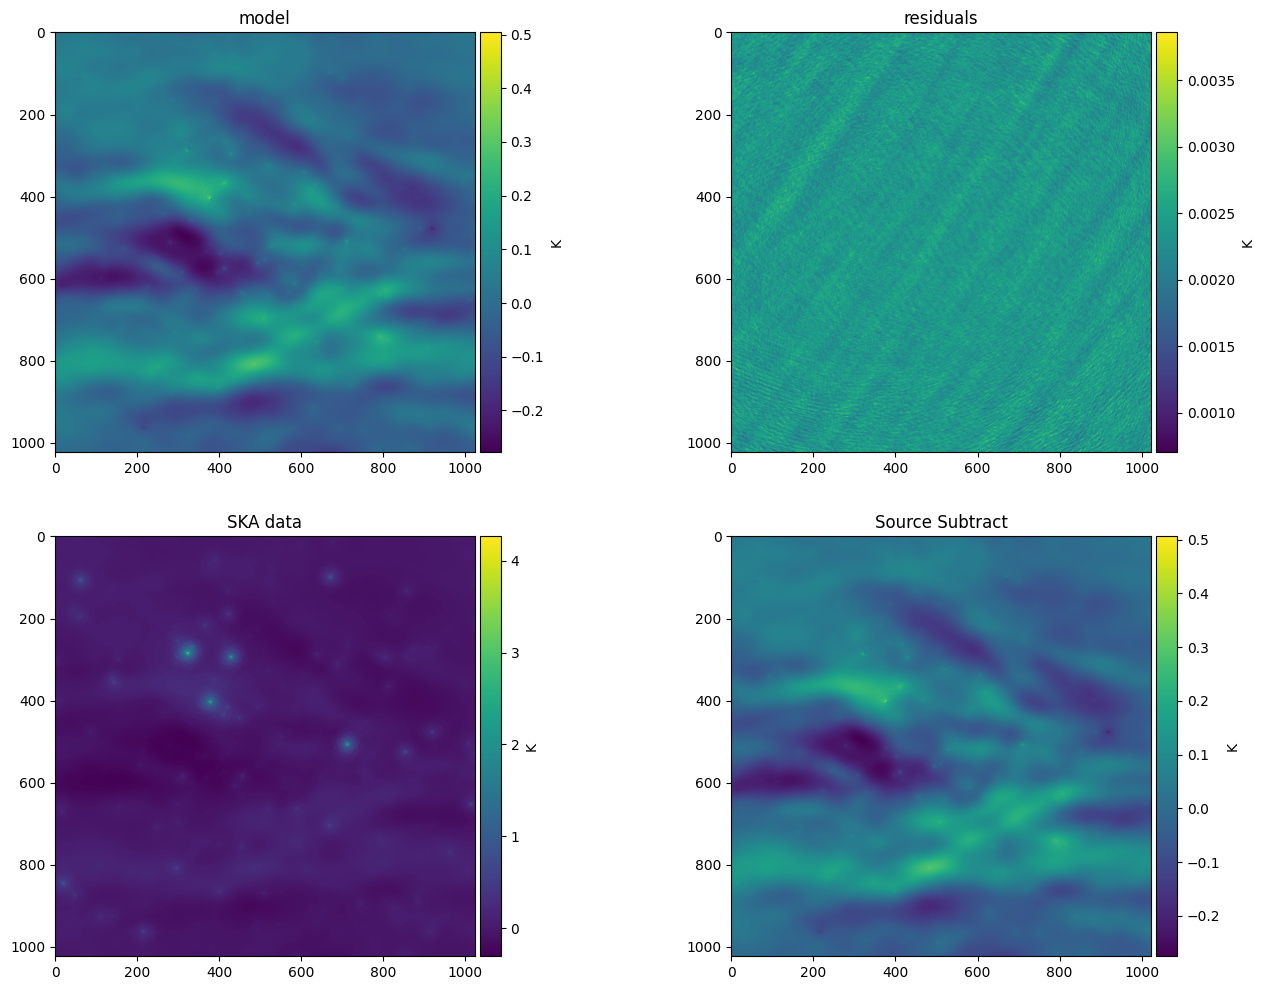

cc between residuals: -0.024170184066327385
cc with source sub: 0.0019595022976000116
cc with ska image: 0.0006581141544140216


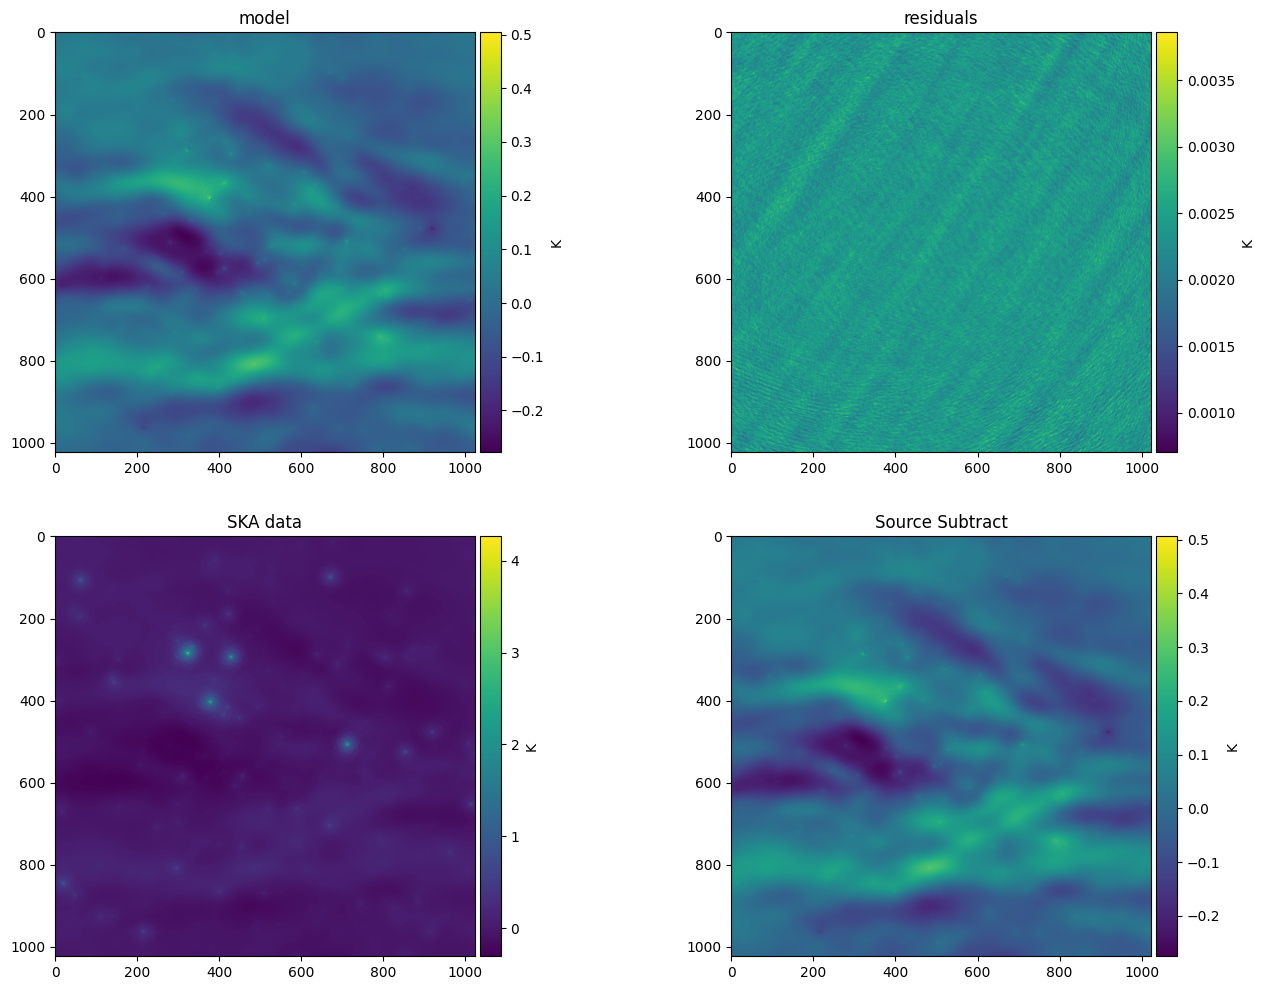

cc between residuals: -0.0241701840663315
cc with source sub: 0.001959502299206633
cc with ska image: 0.0006581141556274573


In [27]:
model1_5mhz, resids1_5mhz = get_plots_cc (freq1_5mhz, 7, arr1)
model1_15mhz, resids1_15mhz = get_plots_cc (freq1_5mhz, 7, arr1)

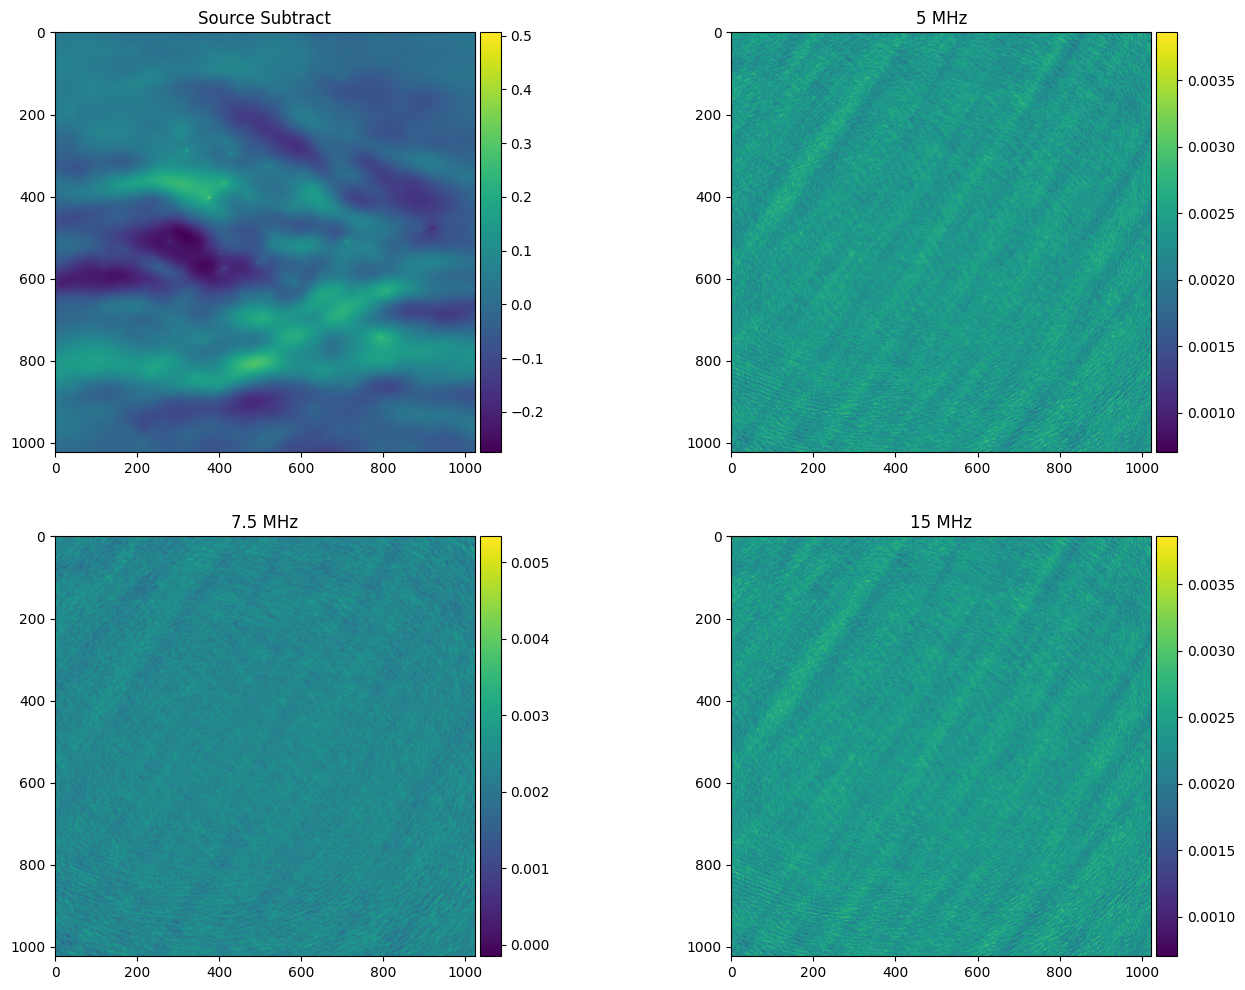

In [31]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(221)
im1 = ax1.imshow(subtract_img[:,:,0])
ax1.set_title('Source Subtract')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(resids1_5mhz[:,:,0])
ax2.set_title('5 MHz')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(resids1[:,:,0])
ax3.set_title('7.5 MHz')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical');

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(resids1_15mhz[:,:,0])
ax4.set_title('15 MHz')

divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical');
plt.savefig('compare_freq_ranges.pdf', dpi=300)
plt.show()

In [ ]:
if CONVOLVE == True:
    model2, resids2 = get_plots_cc (conv2, 5, arr2)
else:
    model2, resids2 = get_plots_cc (freq2, 5, arr2)

In [ ]:
if CONVOLVE == True:
    model3, resids3 = get_plots_cc (conv3, 4, arr3)
else:
    model3, resids3 = get_plots_cc (freq3, 4, arr3)


In [ ]:
if CONVOLVE == True:
    model4, resids4 = get_plots_cc (conv4, 6, arr4)
else:
    model4, resids4 = get_plots_cc (freq4, 6, arr4)

In [ ]:
if CONVOLVE == True:
    model5, resids5 = get_plots_cc (conv5, 7, arr5)
else:
    
    model5, resids5 = get_plots_cc (freq5, 7, arr5)


In [ ]:
if CONVOLVE == True:
    model6, resids6 = get_plots_cc (conv6, 8, arr6)
else:
    model6, resids6 = get_plots_cc (freq6, 8, arr6)

In [ ]:
if CONVOLVE == True:
    model7, resids7 = get_plots_cc (conv7, 7, arr7)
else:
    model7, resids7 = get_plots_cc (freq7, 7, arr7)


In [ ]:

if CONVOLVE == True:
    model8, resids8 = get_plots_cc (conv8, 8, arr8)
else:
    model8, resids8 = get_plots_cc (freq8, 8, arr8)

In [ ]:

if CONVOLVE == True:
    model9, resids9 = get_plots_cc (conv9, 7, arr9)
else:
    model9, resids9 = get_plots_cc (freq9, 7, arr9)

In [ ]:
if CONVOLVE == True:
    model10, resids10 = get_plots_cc (conv10, 6, arr10)
else:
    model10, resids10 = get_plots_cc (freq10, 6, arr10)


In [ ]:
if CONVOLVE == True:
    model11, resids11 = get_plots_cc (conv11, 6, arr11)
else:
    model11, resids11 = get_plots_cc (freq11, 6, arr11)


In [ ]:
if CONVOLVE == True:
    model12, resids12 = get_plots_cc (conv12, 6, arr12)
else:
    model12, resids12 = get_plots_cc (freq12, 6, arr12)



In [ ]:
out = np.empty_like(subtract_img)

out[:,:,0:75] = resids1
out[:,:,75:150] = resids2
out[:,:,150:225]  = resids3
out[:,:,225:300]  = resids4
out[:,:,300:375] = resids5
out[:,:,375:450] = resids6
out[:,:,450:525]  = resids7
out[:,:,525:600] = resids8
out[:,:,600:675]  = resids9
out[:,:,675:750] = resids10
out[:,:,750:825] = resids11
out[:,:,825:901] = resids12

out = np.transpose(out,(2,0,1))

In [ ]:
if CONVOLVE == True:
    fits.writeto(base + 'FastICA_1stgo_resids_allfreqs_Jybeam_conv.fits',out,overwrite=True)
else:
    fits.writeto(base + 'FastICA_1stgo_resids_allfreqs_Jybeam.fits',out,overwrite=True)

In [ ]:
model = np.empty_like(subtract_img)

model[:,:,0:75] = model1
model[:,:,75:150] = model2
model[:,:,150:225]  = model3
model[:,:,225:300]  = model4
model[:,:,300:375] = model5
model[:,:,375:450] = model6
model[:,:,450:525]  = model7
model[:,:,525:600] = model8
model[:,:,600:675]  = model9
model[:,:,675:750] = model10
model[:,:,750:825] = model11
model[:,:,825:901] = model12

model = np.transpose(model,(2,0,1))

if CONVOLVE == True:
    fits.writeto(base + 'FastICA_1stgo_model_allfreqs_Jybeam_conv.fits',model,overwrite=True)
else:
    fits.writeto(base + 'FastICA_1stgo_model_allfreqs_Jybeam.fits',model,overwrite=True)


In [ ]:
out.shape